In [43]:
from torch_geometric.datasets import planetoid
from torch_geometric.loader import DataLoader
import torch_geometric as pyg

In [44]:
dataset = planetoid.Planetoid(root='data/', name='PubMed', split="full")
loader = DataLoader(dataset, batch_size=32, shuffle=True)

Processing...
Done!


In [45]:
dataset[0]

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

In [47]:
from torch_geometric.datasets import Reddit
dataset = Reddit(root='data/Reddit')
dataset[0]

Extracting data/Reddit/raw/reddit.zip
Processing...
Done!


Data(x=[232965, 602], edge_index=[2, 114615892], y=[232965], train_mask=[232965], val_mask=[232965], test_mask=[232965])

In [4]:
dataset.train_mask.shape

torch.Size([2708])

In [5]:
data = dataset[0]
W = pyg.utils.to_dense_adj(data.edge_index)
f = data.x
target = data.y

In [6]:
W.shape

torch.Size([1, 2708, 2708])

In [7]:
A = W[:, dataset.train_mask, :][:,:,dataset.train_mask]
A.shape

torch.Size([1, 1208, 1208])

In [8]:
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [9]:
W = to_dense_adj(data.edge_index)
f = data.x
target = data.y

NameError: name 'to_dense_adj' is not defined

In [ ]:
target.shape

torch.Size([2708])

In [ ]:
print(dataset.x.shape)
print(dataset.y.shape)
print(dataset.edge_index.shape)

torch.Size([2708, 1433])
torch.Size([2708])
torch.Size([2, 10556])


In [ ]:
print(dataset.x.sum(1))

tensor([ 9., 23., 19.,  ..., 18., 14., 13.])


In [ ]:
print(dataset.y.unique(return_counts=True))

(tensor([0, 1, 2, 3, 4, 5, 6]), tensor([351, 217, 418, 818, 426, 298, 180]))


In [ ]:
print(dataset.train_mask.sum())
print(dataset.val_mask.sum())
print(dataset.test_mask.sum())

tensor(140)
tensor(500)
tensor(1000)


In [ ]:
data = dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
from torch_geometric.utils import subgraph
import torch

num_nodes = data.num_nodes
sample_size = num_nodes // 10  # 1/10 of the nodes
data.A = pyg.utils.to_dense_adj(data.edge_index)[0]
sampled_nodes = torch.randperm(num_nodes)[:sample_size]
subgraph_edge_index, subgraph_edge_attr = subgraph(sampled_nodes, data.edge_index, data.edge_attr)
subgraph_data = data.clone()
subgraph_data.edge_index = subgraph_edge_index
subgraph_data.edge_attr = subgraph_edge_attr
subgraph_data.x = data.x[sampled_nodes]
subgraph_data.y = data.y[sampled_nodes]
subgraph_data.train_mask = data.train_mask[sampled_nodes]
subgraph_data.val_mask = data.val_mask[sampled_nodes]
subgraph_data.test_mask = data.test_mask[sampled_nodes]
subgraph_data.A = pyg.utils.to_dense_adj(data.edge_index)[:, sampled_nodes, :][:, :, sampled_nodes]
print(subgraph_data.A.shape)

torch.Size([1, 270, 270])


In [ ]:
dataset.data

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
pyg.utils.to_dense_adj(data.edge_index).shape

torch.Size([1, 2708, 2708])

In [ ]:

A = pyg.utils.to_dense_adj(subgraph_data.edge_index)
degree = A.sum(dim=1).squeeze(dim=0)
print((degree>0).sum())

tensor(75)


In [ ]:
print(subgraph_data)
print(subgraph_data.train_mask.sum())
print(subgraph_data.val_mask.sum())
print(subgraph_data.test_mask.sum())

Data(x=[270, 1433], edge_index=[2, 96], y=[270], train_mask=[270], val_mask=[270], test_mask=[270])
tensor(10)
tensor(53)
tensor(105)


In [ ]:
import torch

A = torch.randn(1,3,3)
X = torch.randn(1,3,2)
print(A)
print(X)
n = A.shape[-1]  # extract dimension
        
# Compute basis
A = A.unsqueeze(dim=1) # N x 1 x n x n
X = X.transpose(-2, -1) # N x D1 x n
diag_part = torch.diagonal(A, dim1=-2, dim2=-1)   # N x 1 x n
mean_diag_part = torch.mean(diag_part, dim=-1).unsqueeze(dim=-1)  # N x 1 x 1
mean_of_cols = torch.mean(A, dim=-1)  # N x 1 x n
mean_all = torch.mean(mean_of_cols, dim=-1).unsqueeze(dim=-1)  # N x 1 x 1
mean_X = torch.mean(X, dim=-1).unsqueeze(dim=-1) #N x D1 x 1
a1 = A
a2 = mean_all.unsqueeze(dim=-1).expand(-1, -1, n, n)
a3 = mean_diag_part.unsqueeze(dim=-1).expand(-1, -1, n, n)
a4 = mean_of_cols.unsqueeze(dim=-1).expand(-1, -1, n, n) + mean_of_cols.unsqueeze(dim=-2).expand(-1, -1, n, n)
a5 = diag_part.unsqueeze(dim=-1).expand(-1, -1, n, n) + diag_part.unsqueeze(dim=-2).expand(-1, -1, n, n)
a6 = X.unsqueeze(dim=-1).expand(-1, -1, n, n) + X.unsqueeze(dim=-2).expand(-1, -1, n, n) # N x D1 x n x n
a7 = mean_X.unsqueeze(dim=-1).expand(-1, -1, n, n) # N x D1 x n x n

tensor([[[-2.4455,  1.0693, -1.5900],
         [ 1.3882,  0.1906,  0.7937],
         [-0.5306,  0.7166, -0.5505]]])
tensor([[[-0.5627, -1.5600],
         [-1.5452,  0.0567],
         [ 2.1319, -1.7710]]])


In [ ]:
a6

tensor([[[[-1.1254, -2.1079,  1.5692],
          [-2.1079, -3.0905,  0.5867],
          [ 1.5692,  0.5867,  4.2638]],

         [[-3.1201, -1.5033, -3.3310],
          [-1.5033,  0.1134, -1.7143],
          [-3.3310, -1.7143, -3.5420]]]])

In [ ]:
mean_of_cols

tensor([[[-0.9887,  0.7908, -0.1215]]])

In [ ]:
import data
import numpy as np
X, idxContact = data.load_data(movie=405, min_ratings=200)
N = X.shape[1]

In [ ]:
print(X.shape)

(943, 118)


In [ ]:

# Creating and sparsifying the graph

nTotal = X.shape[0]
permutation = np.random.permutation(nTotal)
nTrain = int(np.ceil(0.9*nTotal))
idxTrain = permutation[0:nTrain]
nTest = nTotal-nTrain
idxTest=permutation[nTrain:nTotal]

W = data.create_graph(X=X, idxTrain=idxTrain, knn=40)

# Creating the training and test sets

xTrain, yTrain, xTest, yTest = data.split_data(X, idxTrain, idxTest, idxContact)
nTrain = xTrain.shape[0]
nTest = xTest.shape[0]

In [ ]:
W

array([[0.        , 0.        , 0.        , ..., 0.0242602 , 0.        ,
        0.        ],
       [0.02562432, 0.        , 0.        , ..., 0.02433118, 0.        ,
        0.        ],
       [0.02596162, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02488369, 0.        , 0.        , ..., 0.        , 0.02698323,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02561502, 0.        ,
        0.        ],
       [0.02913293, 0.        , 0.02759221, ..., 0.        , 0.02910579,
        0.        ]])

In [ ]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from model import GNN

d = 5
n_samples = 100
p = 0.5
M = int(1e4)  # reference graph size, set to a large number as estimated cts limit
log_n_range = np.arange(1, 4, 0.2)

# fix a Gaussian distribution for features
L = torch.randn(d, d)
mu = torch.randn(d)
cov = L @ L.T
multivariate_normal = torch.distributions.MultivariateNormal(mu, cov)

# fix a model with random weights
model = GNN(in_channels=d, out_channels=1, hidden_channels = 5, num_layers = 3, reduced=False)
model.eval()



GNN(
  (act): ReLU()
  (layers): ModuleList(
    (0): GNN_layer(
      (A_l1): Linear(in_features=5, out_features=1, bias=False)
      (A_l2): Linear(in_features=5, out_features=1, bias=False)
      (X1_l1): Linear(in_features=5, out_features=5, bias=False)
      (X1_l2): Linear(in_features=5, out_features=5, bias=False)
      (X1_l3): Linear(in_features=1, out_features=5, bias=False)
      (X1_l4): Linear(in_features=1, out_features=5, bias=False)
      (X1_l5): Linear(in_features=1, out_features=5, bias=False)
      (X1_l6): Linear(in_features=1, out_features=5, bias=False)
      (X2_l1): Linear(in_features=5, out_features=5, bias=False)
      (X2_l2): Linear(in_features=5, out_features=5, bias=False)
      (X2_l3): Linear(in_features=1, out_features=5, bias=False)
      (X2_l4): Linear(in_features=1, out_features=5, bias=False)
      (X2_l5): Linear(in_features=1, out_features=5, bias=False)
      (X2_l6): Linear(in_features=1, out_features=5, bias=False)
    )
    (1): ReLU()
    (

In [ ]:
references = np.zeros(n_samples)
for i in range(n_samples):
    A = bernoulli.sample((M, M)).float()
    A = A.tril(diagonal=-1) + A.tril(diagonal=-1).T
    A = A.unsqueeze(0)
    X = multivariate_normal.sample((M,)).unsqueeze(0)
    with torch.no_grad():
        references[i] = model(A, X).mean()
    

In [ ]:
reference = float(references.mean())
print(reference)

-37.84013080596924


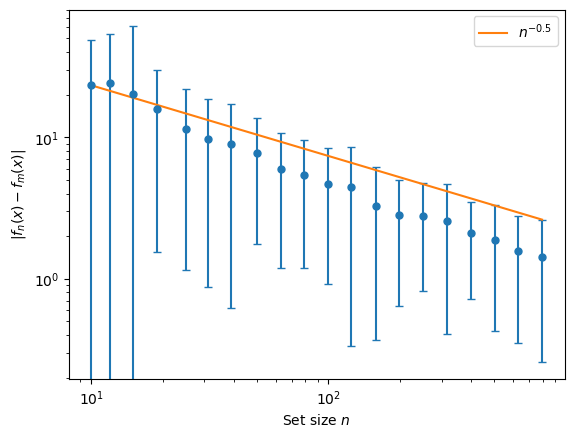

In [ ]:
log_n_range = np.arange(1, 3, 0.1)
# compute errors
n_range = np.power(10, log_n_range).astype(int)
errors_mean = np.zeros_like(n_range, dtype=float)
errors_std = np.zeros_like(n_range, dtype=float)
for i, n in enumerate(n_range):
    A = bernoulli.sample((n_samples, n, n)).float()
    A = A.tril(diagonal=-1) + A.tril(diagonal=-1).transpose(-1, -2)
    X = multivariate_normal.sample(
        (
            n_samples,
            n,
        )
    )
    with torch.no_grad():
        y = model(A,X).mean(dim=1).squeeze()
    error = torch.abs(y - reference)
    errors_mean[i] = float(error.mean().squeeze())
    errors_std[i] = float(error.std().squeeze())

# plot
plt.figure()
plt.errorbar(n_range, errors_mean, errors_std, fmt="o", capsize=3, markersize=5)
y = n_range ** (-0.5) * n_range[0] ** (0.5) * errors_mean[0]
plt.plot(n_range, y, label="$n^{-0.5}$")
plt.xlabel("Set size $n$")
plt.ylabel("$|f_n(x) - f_m(x)|$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
y.shape

torch.Size([100])

In [31]:
import torch
import os
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.datasets import Planetoid
import pdb


class SubsampledDataset(InMemoryDataset):
    def __init__(self, root, dataset_name, n_samples, n_nodes, transform=None, pre_transform=None):
        os.makedirs(root, exist_ok=True)
        self.dataset_name = dataset_name
        self.n_samples = n_samples
        self.n_nodes = n_nodes
        super(SubsampledDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [self.dataset_name]

    @property
    def processed_file_names(self):
        return [f"{self.dataset_name}_{self.n_samples}_{self.n_nodes}.pt"]

    def process(self):
        if self.dataset_name == "Cora":
            data = Planetoid(self.root, "Cora")[0]
        else:
            raise ValueError(f"Dataset {self.dataset_name} is not supported.")

        W = to_dense_adj(data.edge_index)[:, data.train_mask, :][:, :, data.train_mask]
        f = data.x[data.train_mask, :]
        target = data.y[data.train_mask]
        n = W.shape[-1]
        z = torch.randint(0, n, (self.n_samples, self.n_nodes))
        data_list = []
        for i in range(self.n_samples):
            A = torch.zeros(self.n_nodes, self.n_nodes)
            X = torch.zeros(self.n_nodes, f.shape[-1])
            for j in range(self.n_nodes):
                X[j,:] = f[z[i,j],:]
                for k in range(self.n_nodes):
                    # pdb.set_trace()
                    A[j, k] = W[:,z[i,j], z[i,k]]
            data_list.append(Data(x=X, edge_index=dense_to_sparse(A)[0], y=target[z[i]]))
        torch.save(self.collate(data_list), self.processed_paths[0])

In [38]:
dataset = Planetoid("data", "Cora")

In [37]:
dataset[4]

Data(x=[100, 1433], edge_index=[2, 20], y=[100])

In [41]:
data=dataset[0]
data[dataset.train_mask]

KeyError: tensor([ True,  True,  True,  ..., False, False, False])